# Evaluate ternary complex prediction results from Gaoqiweng's method
- Source of Gaoqiweng method: https://github.com/gaoqiweng/PROTAC-Model
- Modified version for better compatibility: https://github.com/jackzzs-lab/protac-model-gaoqiweng
- Dir skeleton must be:
  - {decoys}
    - XXXX (PDB ID)
      - frodock_results / rosetta_results
        - cluster_\*_\*.pdb
        - cluster_top3.txt
  - {refs}
    - XXXX_\*\_?(recepter chains)\_\*\_?(target chains)_\*(protac name).pdb

In [10]:
import re
import pickle
import shlex
import traceback
from pathlib import Path
from box import Box
from subprocess import Popen, PIPE
from concurrent.futures import ProcessPoolExecutor, as_completed

from schrodinger.structutils import rmsd

from protactmsub.structure import Atoms
from protactmsub.operation import seq_align
from protactmsub.protac import TernaryComplex
from protactmsub.files import read_one

def parse_ref_meta(ref_f):
    meta = Box()
    match = re.match(r'(\w{4})_(.+)_(\w+)_(.+)_(\w+)_(.+)', ref_f.stem)
    meta.pdb_id = match.group(1)
    meta.target_protein = match.group(2)
    meta.target_chain = match.group(3)
    meta.receptor_protein = match.group(4)
    meta.receptor_chain = match.group(5)
    meta.protac = match.group(6)
    return meta

def parse_clusters(file):
    with open(file) as f:
        for line in f.read().splitlines():
            paras = line.split()
            yield paras[0], paras[2]

def prepare(decoy_f, ref_f):
    decoy = read_one(decoy_f, cls=TernaryComplex)
    ref = read_one(ref_f, cls=TernaryComplex)
    rm = parse_ref_meta(ref_f)
    for c in rm.receptor_chain:
        if c in ref.partners:
            rm.receptor_chain = c
            break
    else:
        raise RuntimeError(f'can not find chain {rm.receptor_chain} in reference')
    return decoy, ref, rm
    
def process_rmsd_ca(decoy_f, ref_f):
    decoy, ref, rm = prepare(decoy_f, ref_f)
    aligner_result = seq_align(ref, [decoy], ref_asl=f'chain {rm.receptor_chain}', mob_asl=f'chain A')
    aligner_rmsd = float(re.search(r'RMSD:\s([+-]?([0-9]*[.])?[0-9]+)', aligner_result[0][1]).group(1))
    if aligner_rmsd > 1:
        raise RuntimeError(f'can not align {rm.pdb_id}: aligner rmsd = {aligner_rmsd}')
    return rmsd.calculate_in_place_rmsd(decoy, decoy.eval_asl('chain B and atom.ptype CA'),
                                        ref, ref.eval_asl(f'chain {rm.target_chain} and atom.ptype CA'))

def process_rmsd_lig(decoy_f, ref_f):
    decoy, ref, rm = prepare(decoy_f, ref_f)
    aligner_result = seq_align(ref, [decoy], ref_asl=f'chain {rm.receptor_chain}', mob_asl=f'chain A')
    aligner_rmsd = float(re.search(r'RMSD:\s([+-]?([0-9]*[.])?[0-9]+)', aligner_result[0][1]).group(1))
    if aligner_rmsd > 1:
        raise RuntimeError(f'can not align {rm.pdb_id}: aligner rmsd = {aligner_rmsd}')
    decoy_lig = decoy.protac.partner_ligand('B')
    ref_lig = ref.protac.partner_ligand(rm.target_chain)
    if len(decoy_lig) != len(ref_lig):
        raise RuntimeError(f'different ligand can not be compared, this error may be caused by wrong bond assignment')
    return rmsd.calculate_in_place_rmsd(decoy, decoy_lig.with_anchors(), ref, ref_lig.with_anchors())

def process_rmsd_anchor(decoy_f, ref_f):
    decoy, ref, rm = prepare(decoy_f, ref_f)
    aligner_result = seq_align(ref, [decoy], ref_asl=f'chain {rm.receptor_chain}', mob_asl=f'chain A')
    aligner_rmsd = float(re.search(r'RMSD:\s([+-]?([0-9]*[.])?[0-9]+)', aligner_result[0][1]).group(1))
    if aligner_rmsd > 1:
        raise RuntimeError(f'can not align {rm.pdb_id}: aligner rmsd = {aligner_rmsd}')
    decoy_anchor = decoy.protac.linker.anchors
    ref_anchor = ref.protac.linker.anchors
    return rmsd.calculate_in_place_rmsd(decoy, decoy_anchor, ref, ref_anchor)

def process_dockq(decoy_f, ref_f):
    decoy, ref, rm = prepare(decoy_f, ref_f)
    p = Popen(shlex.split(f'python ./dockq/DockQ.py {decoy_f} {ref_f} -model_chain1 A -model_chain2 B -native_chain1 {rm.receptor_chain} -native_chain2 {rm.target_chain}'), stdout=PIPE, stderr=PIPE)
    out, err = p.communicate()
    if err:
        raise RuntimeError(err)
    return float(out.decode().splitlines()[-1].split()[1])

In [11]:
# configs
decoy_dir = Path('/home/zhesheng/proj/protac-ternary-modelling/gaoqiweng/data/crystal_results')
ref_dir = Path('/home/zhesheng/proj/protac-ternary-modelling/gaoqiweng/data/crystal/ref')
phase = 'rosetta_results'

In [12]:
jobs = {}
results = {}
with ProcessPoolExecutor(max_workers=48) as executor:
    for pdbid in decoy_dir.iterdir():
        if pdbid.is_dir():
            results[pdbid.stem] = {}
            print(f'Info: analyzing results of {pdbid.stem} ({phase}).')
            for f in ref_dir.glob(f'{pdbid.stem}_*.pdb'):
                ref = f
                break
            else:
                print(f'Warning: reference pdb of {pdbid.stem} is missing.')
            if (pdbid / phase).is_dir():
                for decoy_id, cluster_id in parse_clusters(pdbid / phase / 'cluster_top3.txt'):
                    decoy = pdbid / phase / f'cluster_{cluster_id}_{decoy_id}.pdb'
                    jobs[executor.submit(process_dockq, decoy, ref)] = (pdbid.stem, decoy_id)
    for future in as_completed(jobs):
        pdb_id, decoy_id = jobs[future]
        try:
            results[pdb_id][decoy_id] = future.result()
        except Exception as e:
            print(f'Error when processing {pdb_id} decoy {decoy_id}: {e}')
        else:
            pass
            # print(f'Finished processing {pdb_id} decoy {decoy_id}.')

Info: analyzing results of 7PI4 (rosetta_results).
Info: analyzing results of 6HAX (rosetta_results).
Info: analyzing results of 6BN7 (rosetta_results).
Info: analyzing results of 5T35 (rosetta_results).
Info: analyzing results of 7KHH (rosetta_results).
Info: analyzing results of 6ZHC (rosetta_results).
Info: analyzing results of 6W8I (rosetta_results).
Info: analyzing results of 7JTP (rosetta_results).
Info: analyzing results of .ipynb_checkpoints (rosetta_results).
Info: analyzing results of 7JTO (rosetta_results).
Info: analyzing results of 7Q2J (rosetta_results).
Info: analyzing results of 6W7O (rosetta_results).
Info: analyzing results of 6HAY (rosetta_results).
Info: analyzing results of 6HR2 (rosetta_results).
Info: analyzing results of 6BOY (rosetta_results).


In [13]:
import pickle
with open('cache.pickle', 'wb') as f:
    pickle.dump(results, f, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
with open('cache.pickle', 'rb') as f:
    results = pickle.load(f)

In [27]:
altered = []
ranges = [0, 0.1, 0.23, 0.49, 0.8, 1]
#ranges = [0,0.5,2.5,5,10,15]
#ranges = [0,0.3,1.0,2.0,5.0,10.0]
predictor = 'DockQ'
# labels = [
#  f'Incorrect ({predictor} >= {ranges[5]})',
#  f'Very weak hit ({ranges[4]} <= {predictor} < {ranges[5]})',
#  f'Weak hit ({ranges[3]} <= {predictor} < {ranges[4]})',
#  f'Midium hit ({ranges[2]} <= {predictor} < {ranges[3]})',
#  f'Usable hit ({ranges[1]} <= {predictor} < {ranges[2]})',
#  f'Accurate ({ranges[0]} <= {predictor} < {ranges[1]})']

labels = [
     f'Incorrect ({ranges[0]} <= {predictor} < {ranges[1]})',
     f'Very weak hit ({ranges[1]} <= {predictor} < {ranges[2]})',
     f'Weak hit ({ranges[2]} <= {predictor} < {ranges[3]})',
     f'Midium hit ({ranges[3]} <= {predictor} < {ranges[4]})',
     f'Usable hit ({ranges[4]} <= {predictor} < {ranges[5]})',
     f'Accurate ({predictor} >= {ranges[5]})']

def label(predictor):
    if ranges[0] <= predictor < ranges[1]:
        return labels[0]
    elif ranges[1] <= predictor < ranges[2]:
        return labels[1]
    elif ranges[2] <= predictor < ranges[3]:
        return labels[2]
    elif ranges[3] <= predictor < ranges[4]:
        return labels[3]
    elif ranges[4] <= predictor < ranges[5]:
        return labels[4]
    elif predictor >= ranges[5]:
        return labels[5]
    else:
        raise ValueError(f'The rmsd score should larger than {ranges[0]}. The current value is {rmsd}')

for pdb_id, result in results.items():
    for rank, decoy_id in enumerate(sorted(result)):
        altered.append({'PDB ID': pdb_id, 'Top 3 in Cluster Poses Rank Percent': (rank+1)/len(result), 'rmsd': result[decoy_id], 'Label': label(result[decoy_id])})

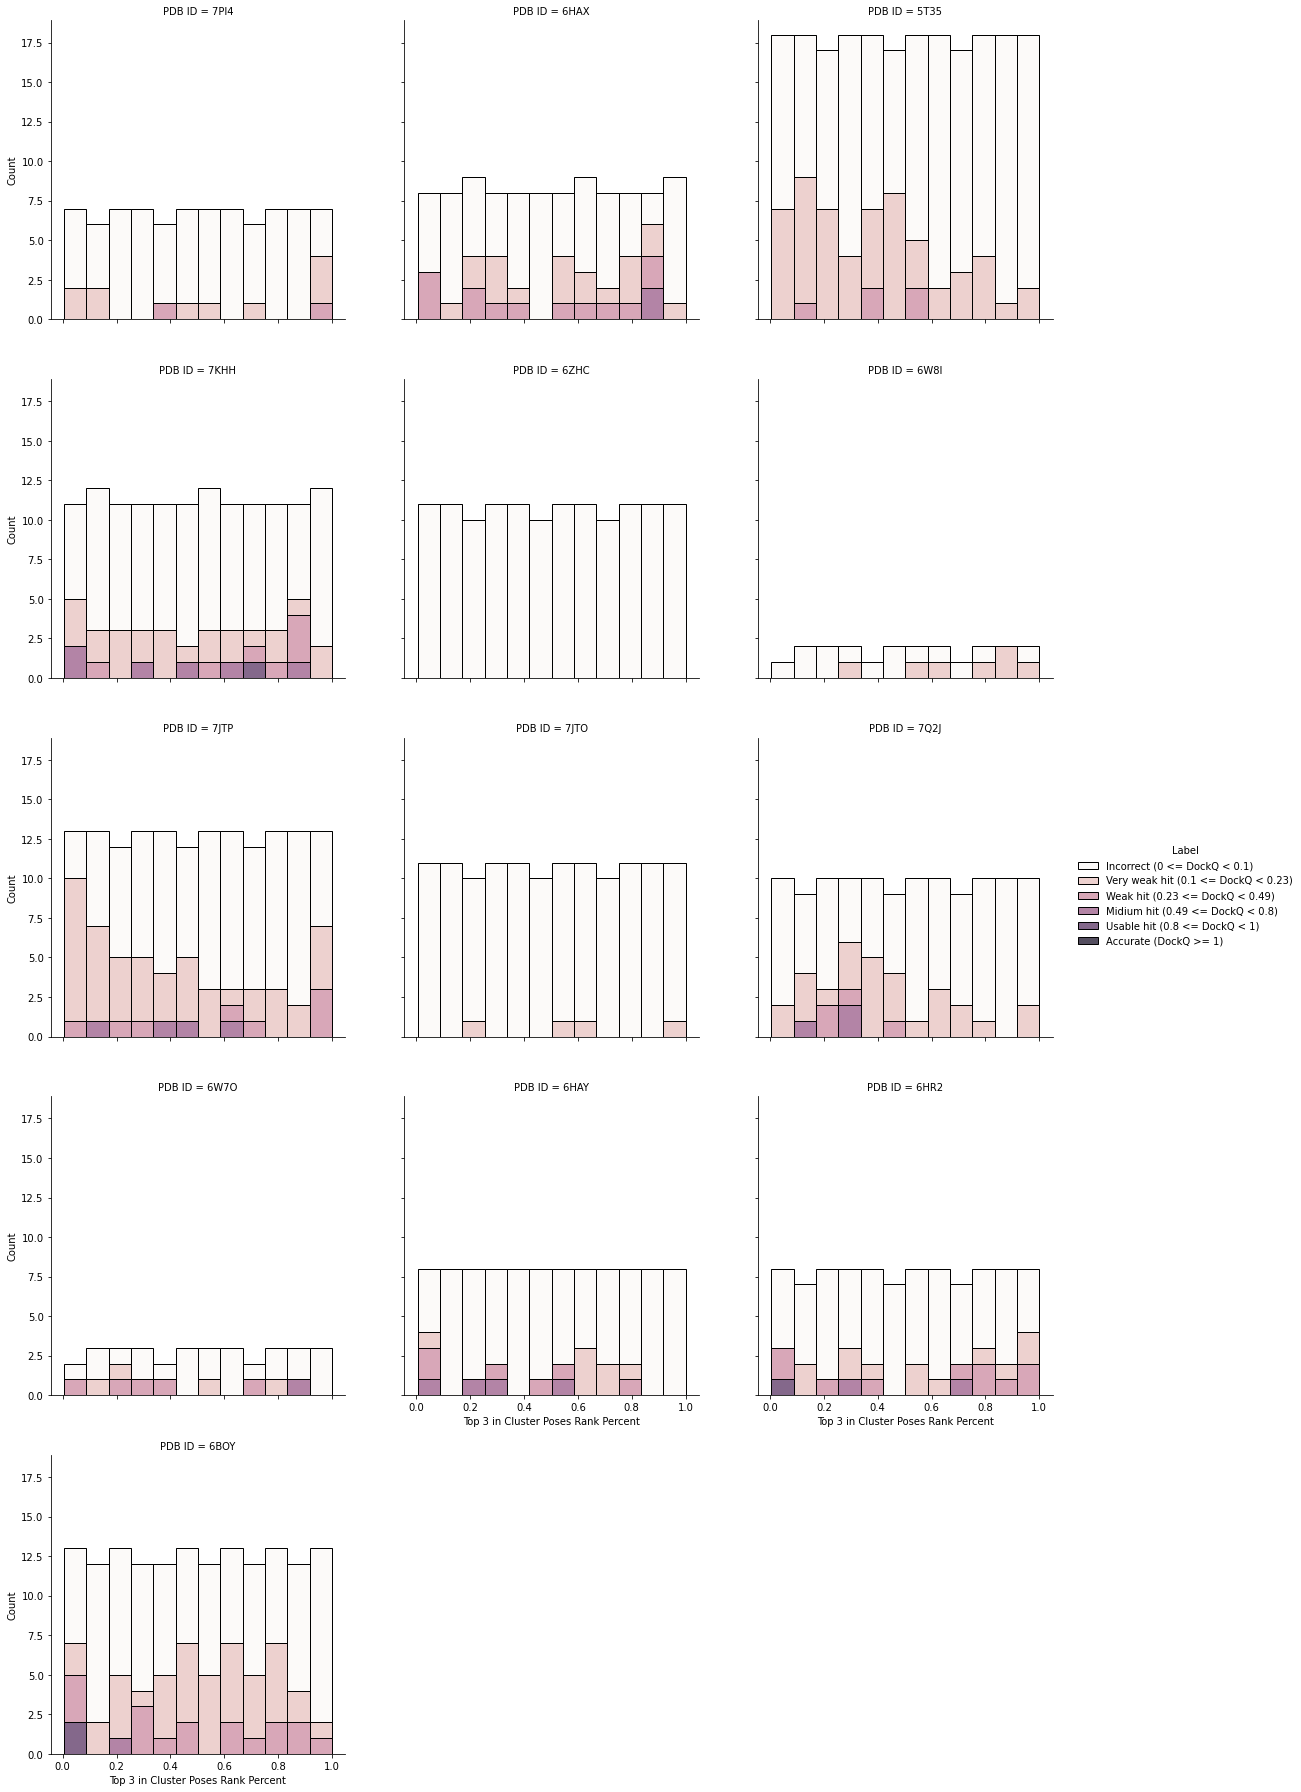

In [28]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(altered)
g = sns.displot(df, x='Top 3 in Cluster Poses Rank Percent', hue='Label', col='PDB ID', col_wrap=3, multiple='stack', hue_order=labels, palette=sns.cubehelix_palette(len(labels), light=0.98, dark=0.1))
for ax in g.axes:
    plt.setp(ax.get_xticklabels(), visible=True)
plt.subplots_adjust(hspace=0.2, wspace=0.2)